In [1]:
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
with open('rnn-challenge-data.npz', 'rb') as f:
    X = np.load(f)
    data_x = X['data_x']
    data_y = X['data_y']
    val_x = X['val_x']
    val_y = X['val_y']
    test_x = X['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# VALIDATION DATA: INPUT (x) AND OUTPUT (y)
print(val_x.shape, val_x.dtype)
print(val_y.shape, val_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

(400,) <U400
(400,) int64
(100,) <U1200
(100,) int64
(250,) <U2000


In [4]:
def zero_pad_1d(source, target_size = 500):
    source_size = source.size()[-1]
    pad_size = int((target_size - source_size)/2)
    residual = int((target_size - source_size)%2)
    return F.pad(input=source, pad=(pad_size,pad_size+residual), mode='constant', value=0)

def categoryFromOutput(output):
    """Interpret the output of the network, which we know to be a likelihood of each category. 
    We can use Tensor.topk to get the index of the greatest value:"""
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def genSeqToTensor(gen_seq):
    """Turn a sequence of genetic code into a <sequence_length x 1 x n_nucleobases> Tensor."""
    tensor = torch.zeros(1, len(gen_seq))
    for idx, nucleobase in enumerate(gen_seq):
        tensor[0,idx] = nucleobaseIndices[nucleobase]
    return zero_pad_1d(tensor)

nucleobaseIndices = {
    "A":0,
    "C":1,
    "G":2,
    "T":3
}

all_nucleobases = list(nucleobaseIndices.keys())
n_nucleobases = len(nucleobaseIndices)
all_categories = ["class 0","class 1","class 2","class 3","class 4"]
n_categories = len(all_categories)



In [5]:
class GenSeqDataset(torch.utils.data.Dataset):
    def __init__(self, gen_sequences, labels):
        self.gen_sequences = gen_sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        gen_seq= self.gen_sequences[idx]
        gen_seq_tensor = genSeqToTensor( gen_seq)
        label_tensor = self.labels[idx]
        label = all_categories[label_tensor]
        label_tensor = torch.tensor([label_tensor], dtype=torch.long)
        return label, gen_seq, label_tensor, gen_seq_tensor
data_ds = GenSeqDataset(data_x, data_y)
data_dl = torch.utils.data.DataLoader(data_ds, batch_size=4,
                        shuffle=True, num_workers=2)

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(6, 16 , 5)
        self.fc1 = nn.Linear(1952, 120)
        self.drop1 = nn.Dropout()
        self.fc2 = nn.Linear(120, 84)
        self.drop2 = nn.Dropout()
        self.fc3 = nn.Linear(84, n_categories)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop1(F.relu(self.fc1(x)))
        x = self.drop2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [9]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        _,_,labels,inputs = data
        labels = torch.flatten(labels, 0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.003
[1,    20] loss: 0.004
[1,    30] loss: 0.003
[1,    40] loss: 0.003
[1,    50] loss: 0.003
[1,    60] loss: 0.003
[1,    70] loss: 0.002
[1,    80] loss: 0.003
[1,    90] loss: 0.003
[1,   100] loss: 0.003
[2,    10] loss: 0.003
[2,    20] loss: 0.002
[2,    30] loss: 0.003
[2,    40] loss: 0.002
[2,    50] loss: 0.002
[2,    60] loss: 0.003
[2,    70] loss: 0.003
[2,    80] loss: 0.002
[2,    90] loss: 0.003
[2,   100] loss: 0.002
[3,    10] loss: 0.003
[3,    20] loss: 0.002
[3,    30] loss: 0.003
[3,    40] loss: 0.002
[3,    50] loss: 0.002
[3,    60] loss: 0.002
[3,    70] loss: 0.002
[3,    80] loss: 0.003
[3,    90] loss: 0.002
[3,   100] loss: 0.002
[4,    10] loss: 0.002
[4,    20] loss: 0.002
[4,    30] loss: 0.002
[4,    40] loss: 0.001
[4,    50] loss: 0.002
[4,    60] loss: 0.002
[4,    70] loss: 0.002
[4,    80] loss: 0.001
[4,    90] loss: 0.001
[4,   100] loss: 0.002
[5,    10] loss: 0.002
[5,    20] loss: 0.002
[5,    30] loss: 0.001
[5,    40] 

In [ ]:
#PATH = './cifar_net.pth'
#torch.save(net.state_dict(), PATH)

In [10]:
net.eval()

Net(
  (conv1): Conv1d(1, 6, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(6, 16, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=1952, out_features=120, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

/home/center/.pyenv/versions/3.7.9/envs/dl-pt/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/center/.pyenv/versions/3.7.9/envs/dl-pt/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator


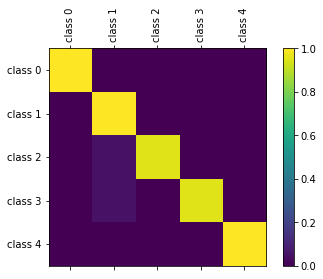

In [11]:
# Load validation dataset
val_ds = GenSeqDataset(val_x, val_y)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=1,
                        shuffle=True, num_workers=0)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = int(200 / len(val_ds))

# Just return an output given a line
def evaluate(line_tensor):
    """Same as train() without the backprop."""
    return net(line_tensor)

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    for category, gen_seq, category_tensor, gen_seq_tensor in val_dl:
        category, gen_seq, category_tensor = category[0], gen_seq[0], category_tensor[0]
        output = evaluate(gen_seq_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [12]:
def predict(input_line, n_predictions=3):
    with torch.no_grad():
        output = evaluate(genSeqToTensor(input_line).unsqueeze(0))
        return categoryFromOutput(output)[1]

prediction = np.fromiter((predict(xi) for xi in test_x), int)
validation = np.fromiter((predict(xi) for xi in val_x), int)

In [13]:
(validation == val_y).sum() / len(val_y)

0.98

In [ ]:
#net = Net()
#net.load_state_dict(torch.load(PATH))

Okay, now let us see what the neural network thinks these examples above are:

